In this file I am experimenting with different reward functions. If I alter the reward function - does the agent actually follow a different strategy.  
This is to get a feel of how much the reward function determines the policy, and as such how good the algorithm is at maximizing the reward given the circumstances.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys


# Find the root directory by traversing up the directory tree
def find_project_root(current_path):
    if os.path.exists(os.path.join(current_path, "README.md")):
        return current_path
    parent_path = os.path.dirname(current_path)
    if parent_path == current_path:
        raise ValueError("Project root not found.")
    return find_project_root(parent_path)


current_dir = os.getcwd()
project_root = find_project_root(current_dir)
sys.path.append(str(project_root))
print(f"Project root: {project_root}")

# flake8: noqa  # Disable Flake8 for the following block
import gymnasium as gym
from src.models.bank_env import BankEnv
from src.models.bank_model import Bankmodel
from src.visualization import visualize
from src.models.evaluate import evaluate_policy
from src.tests import test_bankmodel_a2c_train as tests

log_dir="tmp/"
os.makedirs(log_dir, exist_ok=True)

Project root: f:\OneDrive\Documents\GitHub\rl-alm


Create a base A2C model trained on the environment for comparison

In [2]:
steps = 3_000_000
env_id = "bank-v3"
gym.register(id=env_id, entry_point=BankEnv, max_episode_steps=60)
env = gym.make(env_id, render_mode="human")
env, model = tests.train_model(env, steps=steps, ent_coef=0.01, model_name = 'A2C_Base')

2023-09-30 14:04:03.251 | INFO     | src.data.dataset:read_data:46 - reading interest data from ESW.
2023-09-30 14:04:04.802 | INFO     | src.data.dataset:read_data:46 - reading zerocurve data from ESW.


Interest period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-06-01 00:00:00'))
Zerocurve period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-06-30 00:00:00'))


Show the distibution of funds that the agent has selected

steps: 60, score: 912


f:\OneDrive\Documents\GitHub\rl-alm\rl-alm\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
f:\OneDrive\Documents\GitHub\rl-alm\rl-alm\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
f:\OneDrive\Documents\GitHub\rl-alm\rl-alm\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


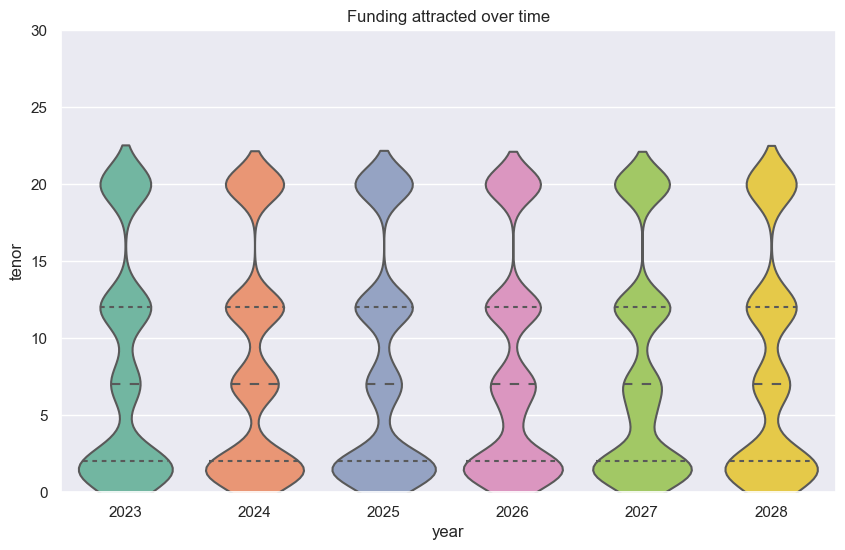

In [3]:
# walk through the model
env, model = tests.test_model(env, model)
sa_funding = env.bankmodel.sa_funding
visualize.plot_funding(sa_funding)

Evaluate the model and plot the results

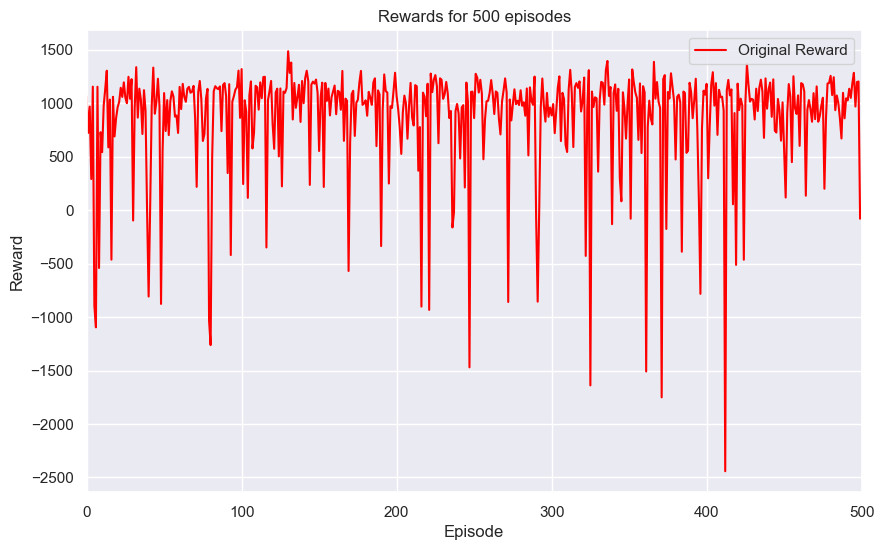

Mean reward: 868.63 +/- 291.75 (IQR) with 500 episodes


In [4]:
mean_reward, iqr, es, rewards = evaluate_policy(model=model, env= env, n_eval_episodes=500, conf_level=0.95)
visualize.plot_rewards(rewards, interpolate_line=False)
print(f"Mean reward: {mean_reward:.2f} +/- {iqr:.2f} (IQR) with {len(rewards)} episodes")

Now to compare this model with a model that is trained on a different reward function we will replace the reward function within the environment.


In [5]:
# Monkey patch the reward function
def get_reward(self):
        nii = 0
        liquidity_penalty = 0
        risk_penalty = self.get_risk_penalty()
        reward = - risk_penalty
        return int(reward), int(nii), int(risk_penalty), int(liquidity_penalty)

Bankmodel.get_reward = get_reward 


In [6]:
env = gym.make(env_id, render_mode="human")
# Train the Risk Only model
env, model = tests.train_model(env, steps=steps, ent_coef=0.01, model_name = 'A2C_Risk_Only')

2023-09-30 20:24:10.708 | INFO     | src.data.dataset:read_data:46 - reading interest data from ESW.
2023-09-30 20:24:12.148 | INFO     | src.data.dataset:read_data:46 - reading zerocurve data from ESW.


Interest period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-06-01 00:00:00'))
Zerocurve period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-06-30 00:00:00'))


steps: 60, score: 0


f:\OneDrive\Documents\GitHub\rl-alm\rl-alm\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
f:\OneDrive\Documents\GitHub\rl-alm\rl-alm\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
f:\OneDrive\Documents\GitHub\rl-alm\rl-alm\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


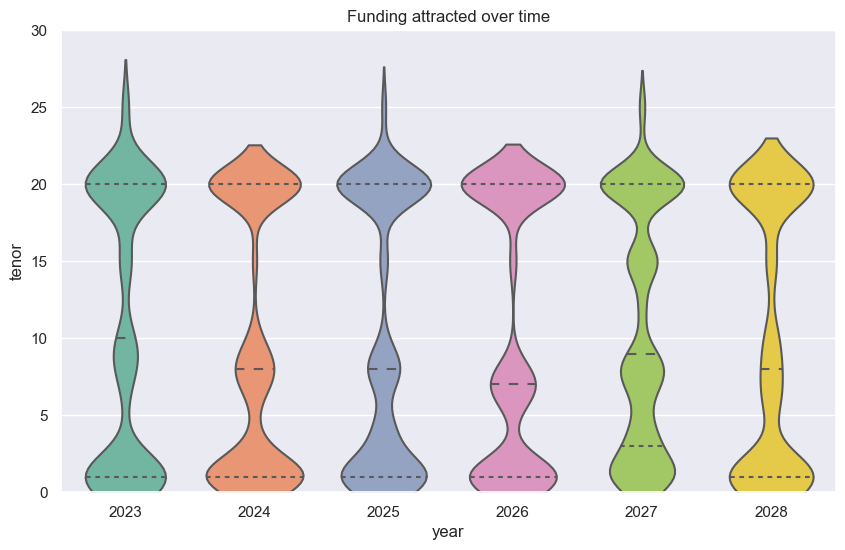

In [7]:
# walk through the model
env, model = tests.test_model(env, model)
sa_funding = env.bankmodel.sa_funding
visualize.plot_funding(sa_funding)

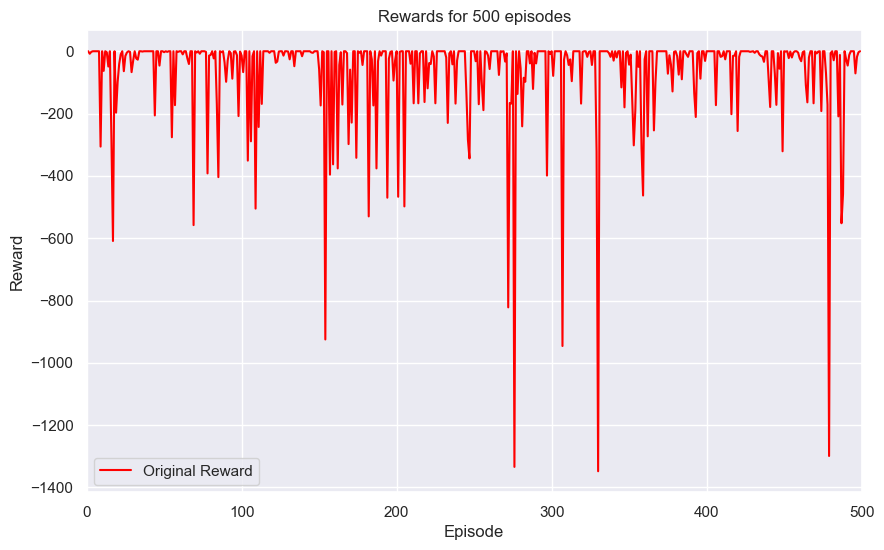

In [8]:
mean_reward, iqr, es, rewards = evaluate_policy(model=model, env= env, n_eval_episodes=500, conf_level=0.95)
visualize.plot_rewards(rewards, interpolate_line=False)


In [9]:
# Monkey patch the reward function - just focus on NII
def get_reward(self):
        nii, income, funding_cost = self.calculate_nii()
        liquidity_penalty = 0
        risk_penalty = self.get_risk_penalty()
        reward = nii
        return int(reward), int(nii), int(risk_penalty), int(liquidity_penalty)

MORTGAGE_AMOUNT = 5000
Bankmodel.get_reward = get_reward

In [10]:
env = gym.make(env_id, render_mode="human")
# Train the model
env, model = tests.train_model(env, steps=steps, ent_coef=0.01, model_name = 'A2C_NII_Only')

2023-10-01 02:15:42.932 | INFO     | src.data.dataset:read_data:46 - reading interest data from ESW.
2023-10-01 02:15:44.465 | INFO     | src.data.dataset:read_data:46 - reading zerocurve data from ESW.


Interest period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-06-01 00:00:00'))
Zerocurve period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-06-30 00:00:00'))


steps: 60, score: 1948


f:\OneDrive\Documents\GitHub\rl-alm\rl-alm\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
f:\OneDrive\Documents\GitHub\rl-alm\rl-alm\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
f:\OneDrive\Documents\GitHub\rl-alm\rl-alm\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


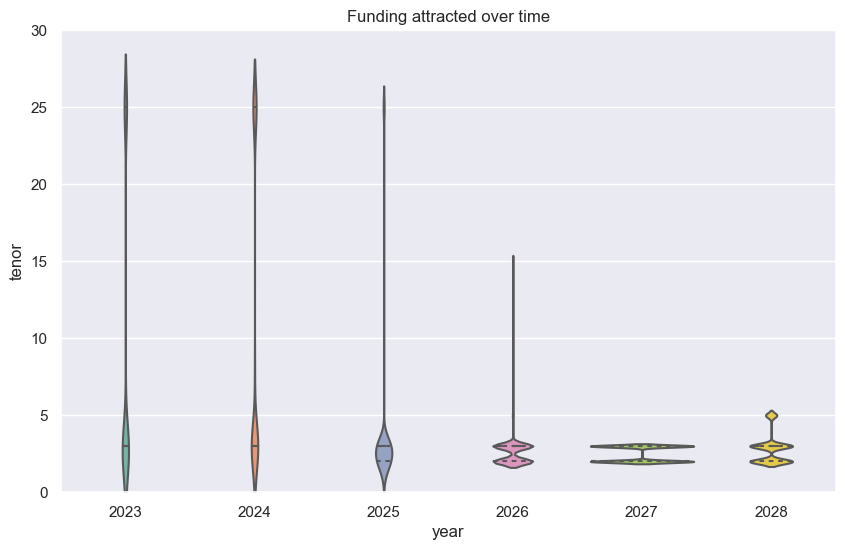

In [11]:
# walk through the model
env, model = tests.test_model(env, model)
sa_funding = env.bankmodel.sa_funding
visualize.plot_funding(sa_funding)

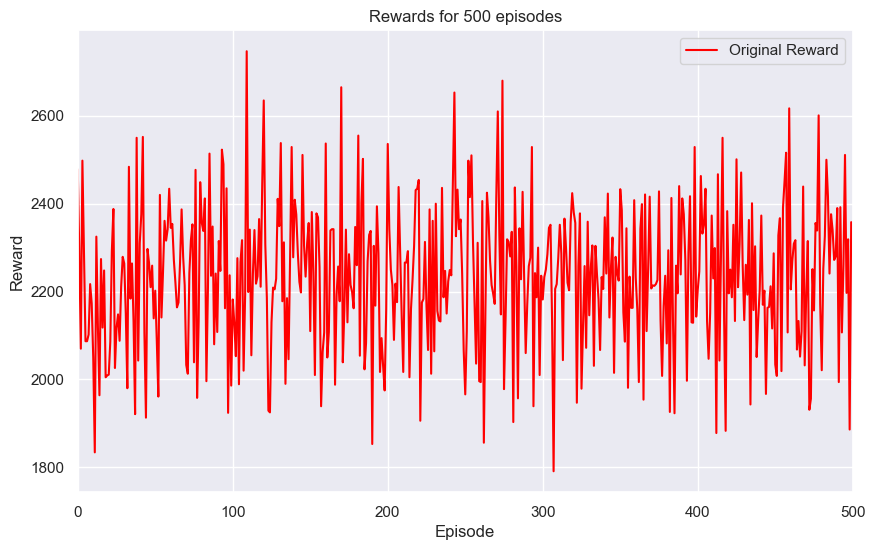

Mean reward: 2233.27 +/- 211.25 (IQR) with 500 episodes


In [12]:
mean_reward, iqr, es, rewards = evaluate_policy(model=model, env= env, n_eval_episodes=500, conf_level=0.95)
visualize.plot_rewards(rewards, interpolate_line=False)
print(f"Mean reward: {mean_reward:.2f} +/- {iqr:.2f} (IQR) with {len(rewards)} episodes")